# Image Processing - Water detection


Idea: 
- create CCCI, NDWI2, NDTI image 
- trhresholding + filtering


In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pylab as plt
from matplotlib.patches import Rectangle, Polygon, Patch
%matplotlib inline

import cv2

In [3]:
import sys
sys.path.append("../common/")

In [4]:
from data_utils import GRID_SIZE, TRAIN_WKT, LABELS, get_resized_polygons, TRAIN_IMAGE_IDS, ALL_IMAGE_IDS
from image_utils import get_image_data, generate_pansharpened, generated_upsampled_swir, generate_label_image
from image_utils import get_common_size
from visu_utils import display_img_1b, display_img_3b, display_img_8b, display_labels, plt_st
from preprocessing_utils import create_pan_rad_inds_ms, create_pan_ms_swir, CCCI_index
from postprocessing_utils import normalize, binarize

In [5]:
def score(y_true, y_pred):
    smooth = 1e-12
    if len(y_true.shape) == 2: 
        y_true = y_true[:,:,None]    
    if len(y_pred.shape) == 2: 
        y_pred = y_pred[:,:,None]        
    y_true = y_true.astype(np.float32)
    y_pred = y_pred.astype(np.float32)
    intersection = np.sum(y_true * y_pred, axis=(0, 1))
    sum_ = np.sum(y_true + y_pred, axis=(0, 1))
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return np.mean(jac)

In [6]:
from otb_preprocessing import compute_rm_indices_image

In [7]:
waterway_test = ['6080_4_3','6080_4_0',
                 '6080_1_3', '6080_1_1',
                 '6150_3_4', '6050_2_1']

water_train = ['6100_1_3', '6110_1_2', '6070_2_3',
     '6140_3_1', '6170_2_4', '6110_4_0',
     '6120_2_2', '6100_2_3', '6100_2_2',
     '6170_0_4', '6090_2_0', '6140_1_2', '6110_3_1']

```
Web : Coastal, Blue, Green, Yellow, Red, Red Edge, Near-IR1, Near-IR2
         1       2    3       4      5      6          7        8
         0       1    2       3      4      5          6        7   
```         

In [8]:
user_channels_dict = {
    'red': ('3b', 0),
    'green': ('3b', 1), 
    'blue': ('3b', 2),
    'nir': ('ms', 6),
    'mir': ('ms', 7)
}

In [43]:
channels = ['ndwi2', 'ndti', 'ndpi', 'mndwi']
#image_id = waterway_test[0]
# image_id = water_train[0]
image_id = "6070_2_3"


img_3b = get_image_data(image_id, '3b')
label_image = get_image_data(image_id, 'label')
y_true = label_image[:,:,7] + label_image[:,:,8]

def compute_water_indices(image_id):
    ccci_img = CCCI_index(image_id)
    rad_indcs_img = compute_rm_indices_image(image_id, channels, user_channels_dict)
    # inverse ndpi
    ndpi = rad_indcs_img[:,:,channels.index('ndpi')]
    rad_indcs_img[:,:,channels.index('ndpi')] = ndpi.max() + ndpi.min() - ndpi
    return ccci_img, rad_indcs_img

ccci_img, rad_indcs_img = compute_water_indices(image_id)

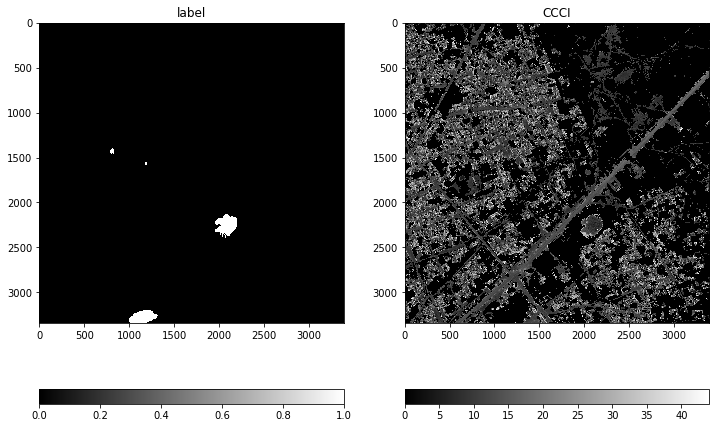

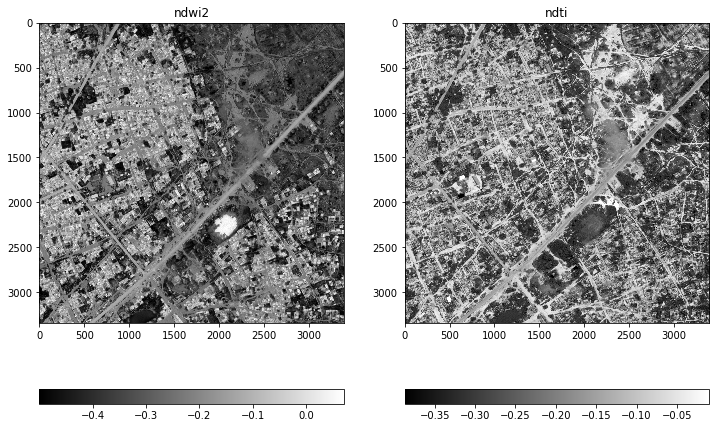

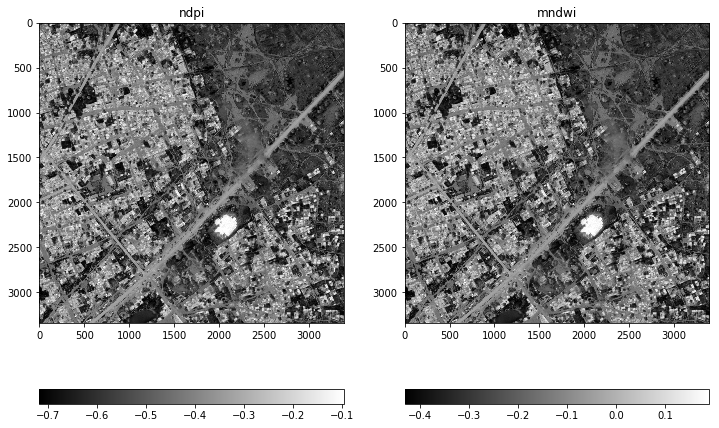

In [25]:
plt_st(12, 8)
plt.subplot(121)
display_img_1b(y_true)
plt.title("label")
plt.subplot(122)
display_img_1b(ccci_img)
plt.title("CCCI")
plt_st(12, 8)

m = 2
for i in range(rad_indcs_img.shape[2]):
    if i % m == 0:
         plt_st(12, 8)
    plt.subplot(1, m, i % m +1)
    display_img_1b(rad_indcs_img[:,:,i])
    plt.title("%s" % channels[i])

Optimum search for each radiometric index

In [9]:
channels = ['ndwi2',]

In [10]:
# Load all permanent data

rad_indcs_imgs = []
y_true_list = []

for i, image_id in enumerate(water_train):
    print "--", image_id, i+1, "/", len(water_train)
    rad_indcs_img = compute_rm_indices_image(image_id, channels, user_channels_dict)    
    rad_indcs_imgs.append(rad_indcs_img)
    label_image = get_image_data(image_id, 'label')
    y_true = label_image[:,:,7] + label_image[:,:,8]
    y_true_list.append(y_true)

-- 6100_1_3 1 / 13
-- 6110_1_2 2 / 13
-- 6070_2_3 3 / 13
-- 6140_3_1 4 / 13
-- 6170_2_4 5 / 13
-- 6110_4_0 6 / 13
-- 6120_2_2 7 / 13
-- 6100_2_3 8 / 13
-- 6100_2_2 9 / 13
-- 6170_0_4 10 / 13
-- 6090_2_0 11 / 13
-- 6140_1_2 12 / 13
-- 6110_3_1 13 / 13


In [15]:
total_score = 0

index = 0
threshold = 0.4
size = 110
iters = 5

for i, image_id in enumerate(water_train):
    print "--", image_id, i, "/", len(water_train)
    y_true = y_true_list[i]
    ri_img = rad_indcs_imgs[i][:,:,0]
    h, w = get_common_size(y_true, ri_img)    
    bin_img = binarize(ri_img, threshold=threshold, size=size, iters=iters)
    s = score(y_true[:h,:w], bin_img[:h,:w])
    
    print "Score: ",s
    total_score += s

total_score /= len(water_train)
print "Total score : ", total_score

-- 6100_1_3 0 / 13
Score:  0.438503
-- 6110_1_2 1 / 13
Score:  0.0016151
-- 6070_2_3 2 / 13
Score:  0.785732
-- 6140_3_1 3 / 13
Score:  0.00861781
-- 6170_2_4 4 / 13
Score:  8.65052e-16
-- 6110_4_0 5 / 13
Score:  0.0324757
-- 6120_2_2 6 / 13
Score:  0.00245391
-- 6100_2_3 7 / 13
Score:  1.68719e-17
-- 6100_2_2 8 / 13
Score:  0.212366
-- 6170_0_4 9 / 13
Score:  4.89476e-16
-- 6090_2_0 10 / 13
Score:  2.63706e-17
-- 6140_1_2 11 / 13
Score:  0.0019236
-- 6110_3_1 12 / 13
Score:  0.00879505
Total score :  0.114806334622


Brute-force search

In [ ]:
from scipy import optimize

def func(params):
    t, s = params
    iters = 1
    total_score = 0
    for i, image_id in enumerate(water_train):        
        y_true = y_true_list[i]
        ri_img = rad_indcs_imgs[i][:,:,0]
        h, w = get_common_size(y_true, ri_img)    
        bin_img = binarize(ri_img, t, s, int(iters))
        s = score(y_true[:h,:w], bin_img[:h,:w])
        total_score += s
    total_score /= len(water_train)
    return -total_score

resbrute = optimize.brute(func,(slice(0.0, 1.0, 0.05), slice(50, 210, 20)), full_output=True, finish=optimize.fmin)

print "Threshold : ", resbrute[0], "Score: ", -resbrute[1]

A machine learning approach

In [ ]:
train_ids = TRAIN_IMAGE_IDS


In [19]:
# plt_st(12, 8)
# plt.subplot(121)
# display_img_1b(ccci_img)
# plt.title("3b")
# plt.subplot(122)
# display_img_1b(binarize(ccci_img, 0.125, size=110, iters=3))

# print score(y_true, binarize(ccci_img, 0.125, iters=3))

In [19]:
# plt_st(12, 8)
# plt.subplot(131)
# display_img_1b(rad_indcs_img[:,:,0])
# plt.title("3b")
# plt.subplot(132)
# display_img_1b(binarize(rad_indcs_img[:,:,0], 0.5))
# plt.subplot(133)
# display_img_1b(y_true, clim=[0, 1])

In [16]:
from scipy import optimize

h, w = get_common_size(y_true, ccci_img)

def func(t):
    bin_img = binarize(ccci_img, t, size=110, iters=5)
    return -score(y_true[:h,:w], bin_img[:h,:w])

resbrute = optimize.brute(func,(slice(0.0, 1.0, 0.025),),full_output=True, finish=optimize.fmin)

print "Threshold : ", resbrute[0], "Score: ", -resbrute[1]

Threshold :  [ 0.125] Score:  0.0244729556143


In [51]:
for i in range(rad_indcs_img.shape[2]):
    ri_img = rad_indcs_img[:,:,i]
    h, w = get_common_size(y_true, ri_img)
    
    def func(params):
        t, s, iters = params
        bin_img = binarize(ri_img, t, s, int(iters))
        return -score(y_true[:h,:w], bin_img[:h,:w])

    resbrute = optimize.brute(func,(slice(0.0, 1.0, 0.05), slice(10, 210, 20), [1,2,3]), full_output=True, finish=optimize.fmin)

    print i, "Threshold : ", resbrute[0], "Score: ", -resbrute[1]
    break

0 Threshold :  [   0.40509521  110.30514542    1.01615532] Score:  0.783389389515


0.786956


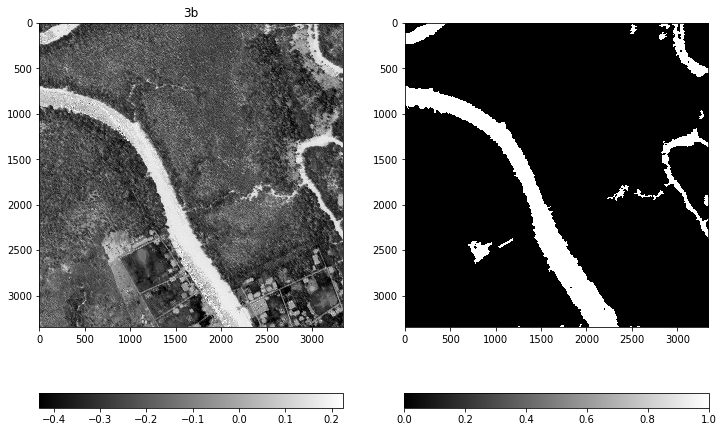

In [56]:
bin_img = binarize(ri_img, threshold=0.40509521, size=110, iters=5)
print score(y_true[:h,:w], bin_img[:h,:w])

plt_st(12, 8)
plt.subplot(121)
display_img_1b(ri_img)
plt.title("3b")
plt.subplot(122)
display_img_1b(bin_img)

In [57]:
for i in range(rad_indcs_img.shape[2]):
    ri_img = rad_indcs_img[:,:,i]
    h, w = get_common_size(y_true, ri_img)
    
    def func(t):
        bin_img = binarize(ri_img, t, size=110, iters=5)
        return -score(y_true[:h,:w], bin_img[:h,:w])

    resbrute = optimize.brute(func,(slice(0.0, 1.0, 0.025),), full_output=True, finish=optimize.fmin)

    print i, "Threshold : ", resbrute[0], "Score: ", -resbrute[1]


0 Threshold :  [ 0.4071875] Score:  0.787058591843
1 Threshold :  [ 0.42553955] Score:  0.480114012957
2 Threshold :  [ 0.45764648] Score:  0.791022181511
3 Threshold :  [ 0.45764648] Score:  0.791022181511


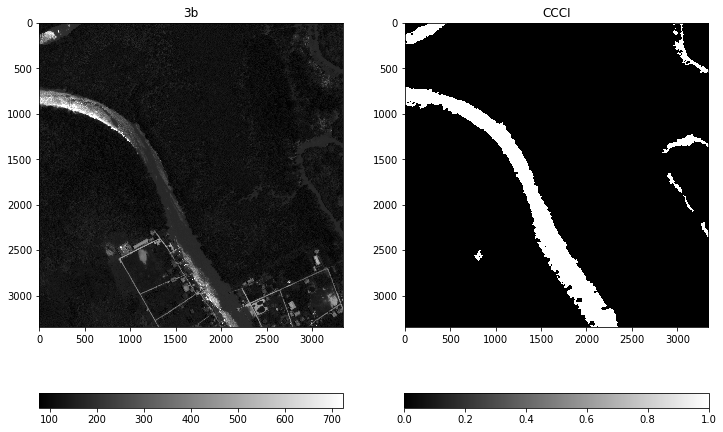

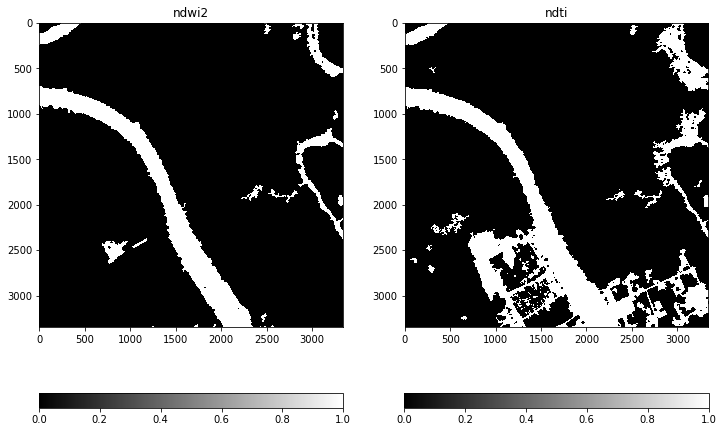

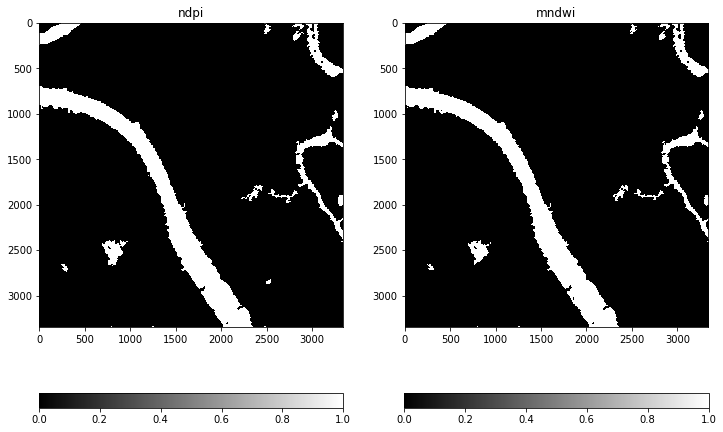

In [60]:
from ipywidgets import interact, IntSlider, FloatSlider  

def interactive_visu(t1, t2, t3, t4, t5):
    plt_st(12, 8)
    plt.subplot(121)
    display_img_1b(img_3b[:,:,0])
    plt.title("3b")
    plt.subplot(122)
    display_img_1b(binarize(ccci_img, t1*0.01, size=110, iters=5))
    plt.title("CCCI")
    
    m = 2
    tt = [t2,t3,t4,t5]
    for i in range(rad_indcs_img.shape[2]):
        if i % m == 0:
             plt_st(12, 8)
        plt.subplot(1, m, i % m +1)
        display_img_1b(binarize(rad_indcs_img[:,:,i], tt[i]*0.01, size=110, iters=5))
        plt.title("%s" % channels[i])


_ = interact(interactive_visu,           
             t1=IntSlider(value=16, min=0, max=100, continuous_update=False), 
             t2=IntSlider(value=40, min=0, max=100, continuous_update=False), 
             t3=IntSlider(value=42, min=0, max=100, continuous_update=False), 
             t4=IntSlider(value=45, min=0, max=100, continuous_update=False),
             t5=IntSlider(value=46, min=0, max=100, continuous_update=False))